<a href="https://colab.research.google.com/github/PreetiSubbiah/License-Plate-Recognition/blob/main/License_Plate_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# License Plate Detection
We will first do an exploratory data analysis on the Large-License-Plate-Detection-Dataset and try to see the distribution of train, valid and test sets. We will also visualize the samples, extract the characters from the license plate, and run a custom YOLOv8 model to recognzie these extracted characters.

In [ ]:
!pip install opencv-contrib-python
!pip install imutils
!pip install scikit-image

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 32.4 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import cv2 as cv
from glob import glob
import os
import random
import string
import easyocr
from ultralytics import YOLO

In [ ]:
from google.colab import drive

mount = '/content/drive'
drive.mount(mount, force_remount=True)

drive_root = mount + '/My Drive/Colab Notebooks/license-plate-recognition'
%cd $drive_root

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/license-plate-recognition


In [ ]:
# !unzip '/content/License-Plate-Recognition-yolov8.zip'

In [ ]:
data_path = os.path.join(drive_root, 'dataset')
train_path = os.path.join(data_path, 'train')
valid_path = os.path.join(data_path, 'valid')
test_path = os.path.join(data_path, 'test')

output_path = drive_root

folders = ['images', 'labels']
print("Data Path: {}\nTrain Path: {}\nValid Path: {}\nTest Path: {}\nOutput Path: {}".format(data_path, train_path, valid_path, test_path, output_path) )

Data Path: /content/drive/My Drive/Colab Notebooks/license-plate-recognition/dataset
Train Path: /content/drive/My Drive/Colab Notebooks/license-plate-recognition/dataset/train
Valid Path: /content/drive/My Drive/Colab Notebooks/license-plate-recognition/dataset/valid
Test Path: /content/drive/My Drive/Colab Notebooks/license-plate-recognition/dataset/test
Output Path: /content/drive/My Drive/Colab Notebooks/license-plate-recognition


## Setting Up Train, Validation and Test Paths

In [ ]:
# Initialize dictionaries of training and classes
train_dict = dict(train=0, valid=1, test=2)
path_dict = [train_path, valid_path, test_path]
class_names = ['License_Plate']
class_dict = dict(zip(range(len(class_names)), class_names))
print(class_dict)

{0: 'License_Plate'}


In [ ]:
## Get filenames and labels information
# Sorting the filenames will make the labels and images in same order
train_filenames = sorted(os.listdir(os.path.join(train_path, folders[0])))
valid_filenames = sorted(os.listdir(os.path.join(valid_path, folders[0])))
test_filenames = sorted(os.listdir(os.path.join(test_path, folders[0])))
train_labels = sorted(os.listdir(os.path.join(train_path, folders[1])))
valid_labels = sorted(os.listdir(os.path.join(valid_path, folders[1])))
test_labels = sorted(os.listdir(os.path.join(test_path, folders[1])))

In [ ]:
t_f, v_f, te_f = [sorted(os.listdir(os.path.join(path_dict[i], folders[0]))) for i in range(len(path_dict))]
t_l, v_l, te_l = [sorted(os.listdir(os.path.join(path_dict[i], folders[1]))) for i in range(len(path_dict))]

In [ ]:
# Check whether images from both sources are the same
train_filenames == t_f, valid_filenames==v_f, test_filenames==te_f

(True, True, True)

In [ ]:
# Check whether labels from both sources are the same results
train_labels==t_l, valid_labels==v_l, test_labels==te_l

(True, True, True)

# Validating the Data

## Check the following:
1. Length of training/validation/test filenames are same as training/validation/test labels

2. Order of training/validation/test filenames are same as training/validation/test labels

3. No leakage of files or duplicate entries in training/validation/test filenames

## Check Number of Images and Labels of Each Folder




In [ ]:
# Checking length of train, valid, test filenames
print("Total Train Files: {}\nTotal Valid Files: {}\nTotal Test Files:{}".format(len(train_filenames), len(valid_filenames), len(test_filenames)))

Total Train Files: 21173
Total Valid Files: 2046
Total Test Files:1019


In [ ]:
# Check whether filenames and labels are of same length
len(train_filenames)==len(train_labels), len(valid_filenames)==len(valid_labels), len(test_filenames)==len(test_labels)

(True, True, True)

## Check Order
We will check the order of filenames and labels to make sure that each image has the same label annotation name as that of the image. This will ensure that we are not using annotations and label information for a different image.

In [ ]:
[item.split('.')[0] for item in train_filenames]==[item.split('.')[0] for item in train_labels],\
[item.split('.')[0] for item in valid_filenames]==[item.split('.')[0] for item in valid_labels],\
[item.split('.')[0] for item in test_filenames]==[item.split('.')[0] for item in test_labels]

(True, True, True)

## Check Leakage
We will check whether any filename is present in more than one set. This is known as leakage in datasets. If some filenames are common in more than one set say training or validation, then the training will not be dependable.
Always check the above listed three things before proceeding with EDA or pre-processing.

In [ ]:
set(train_filenames).intersection(set(valid_filenames)),\
set(valid_filenames).intersection(set(test_filenames)),\
set(test_filenames).intersection(set(train_filenames))

(set(), set(), set())

In [ ]:
df = pd.DataFrame()
df['filenames'] = train_filenames + valid_filenames + test_filenames
df['labelnames'] = train_labels + valid_labels + test_labels
df['train_id'] = [0]*len(train_filenames) + [1]*len(valid_filenames) + [2]*len(test_filenames)
df.tail()

,filenames,labelnames,train_id
24233,xemayBigPlate54_jpg.rf.114c1decbaf72fa79d414c8...,xemayBigPlate54_jpg.rf.114c1decbaf72fa79d414c8...,2
24234,xemayBigPlate56_jpg.rf.d2532585ef9387fa09ee246...,xemayBigPlate56_jpg.rf.d2532585ef9387fa09ee246...,2
24235,xemayBigPlate59_jpg.rf.dedc9211d784530a1602af5...,xemayBigPlate59_jpg.rf.dedc9211d784530a1602af5...,2
24236,xemayBigPlate62_jpg.rf.f2b53d7accfed68b1ed2036...,xemayBigPlate62_jpg.rf.f2b53d7accfed68b1ed2036...,2
24237,xemayBigPlate9_jpg.rf.e14a5d236e1ab696bf272f56...,xemayBigPlate9_jpg.rf.e14a5d236e1ab696bf272f56...,2


In [ ]:
df.filenames.duplicated().value_counts()

filenames
False    24238
Name: count, dtype: int64

In [ ]:
df.train_id.value_counts()

train_id
0    21173
1     2046
2     1019
Name: count, dtype: int64

<Axes: title={'center': 'Train-Val-Test Split'}, xlabel='train_id'>

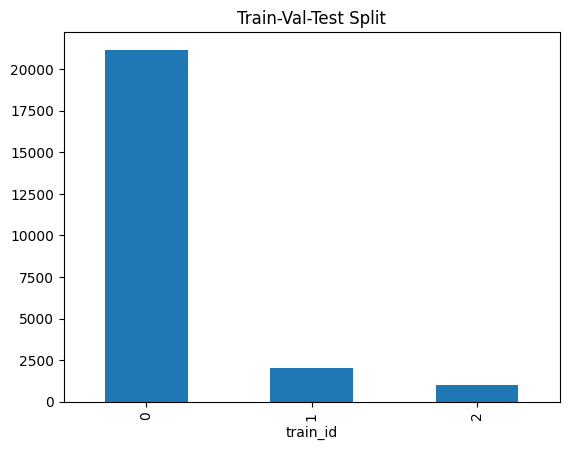

In [ ]:
df.train_id.value_counts().plot(kind = 'bar', title = 'Train-Val-Test Split')

##Training YOLOv8 Model to Detect License Plates

In [ ]:
 # Load a pre-trained model
custom_model_small = YOLO("yolov8n.pt")

In [ ]:
results_small = custom_model_small.train(data='/content/drive/My Drive/Colab Notebooks/license-plate-recognition/data.yaml', epochs=25)  # Train the model

Ultralytics YOLOv8.2.45 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/My Drive/Colab Notebooks/license-plate-recognition/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

train: Scanning /content/drive/My Drive/Colab Notebooks/license-plate-recognition/dataset/train/labels.cache... 21173 images, 28 backgrounds, 0 corrupt: 100%|██████████| 21173/21173 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/My Drive/Colab Notebooks/license-plate-recognition/dataset/valid/labels.cache... 2046 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2046/2046 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.27G      1.233     0.7097      1.268         20        640: 100%|█████████▉| 1323/1324 [32:27<00:02,  2.14s/it]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/25      4.29G      1.233       0.71      1.268          3        640: 100%|██████████| 1324/1324 [32:30<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.76it/s]


                   all       2046       2132       0.93      0.855      0.923      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      4.44G      1.284     0.7689      1.301          8        640: 100%|██████████| 1324/1324 [10:41<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.86it/s]

                   all       2046       2132      0.947      0.905      0.947      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      4.48G       1.26      0.741      1.287          6        640: 100%|██████████| 1324/1324 [10:36<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.76it/s]

                   all       2046       2132      0.953      0.899      0.945       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      4.47G      1.227     0.6998      1.266          8        640: 100%|██████████| 1324/1324 [10:38<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.82it/s]

                   all       2046       2132       0.95      0.914      0.955      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      4.47G      1.201     0.6575      1.247         11        640: 100%|██████████| 1324/1324 [10:36<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]

                   all       2046       2132       0.98      0.927      0.966      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      4.46G      1.172     0.6236      1.225         11        640: 100%|██████████| 1324/1324 [10:38<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.75it/s]

                   all       2046       2132       0.97      0.938      0.971       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      4.46G      1.157     0.6048      1.216         10        640: 100%|██████████| 1324/1324 [10:34<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.80it/s]

                   all       2046       2132      0.962      0.937      0.967      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      4.46G      1.134     0.5835      1.202         10        640: 100%|██████████| 1324/1324 [10:50<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.77it/s]

                   all       2046       2132      0.969      0.937      0.973      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      4.47G       1.13     0.5697        1.2          8        640: 100%|██████████| 1324/1324 [11:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:37<00:00,  1.70it/s]

                   all       2046       2132      0.972      0.951      0.977      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      4.47G      1.114     0.5576      1.188          6        640: 100%|██████████| 1324/1324 [11:01<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.85it/s]

                   all       2046       2132      0.972      0.952       0.98      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      4.46G      1.101     0.5443      1.181          3        640: 100%|██████████| 1324/1324 [11:02<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.76it/s]

                   all       2046       2132      0.976      0.945      0.977      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      4.48G      1.088     0.5316      1.171         13        640: 100%|██████████| 1324/1324 [10:47<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:33<00:00,  1.89it/s]

                   all       2046       2132      0.966      0.958       0.98      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      4.48G       1.08     0.5182      1.164         10        640: 100%|██████████| 1324/1324 [10:36<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]

                   all       2046       2132      0.969      0.958       0.98      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      4.47G      1.063     0.5077      1.153          5        640: 100%|██████████| 1324/1324 [10:40<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:38<00:00,  1.67it/s]

                   all       2046       2132      0.972      0.955      0.979       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      4.46G      1.059     0.5008      1.152          8        640: 100%|██████████| 1324/1324 [10:49<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.78it/s]

                   all       2046       2132      0.978      0.961       0.98      0.686


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      4.47G      1.038     0.4189      1.182          5        640: 100%|██████████| 1324/1324 [10:22<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]

                   all       2046       2132      0.974      0.961      0.981      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      4.46G      1.026     0.4114      1.174          5        640: 100%|██████████| 1324/1324 [10:17<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.74it/s]

                   all       2046       2132      0.981      0.951      0.981      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      4.47G      1.002     0.4004      1.159          6        640: 100%|██████████| 1324/1324 [10:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.76it/s]

                   all       2046       2132      0.981      0.956      0.982      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      4.46G     0.9903     0.3903      1.151          5        640: 100%|██████████| 1324/1324 [10:20<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.81it/s]

                   all       2046       2132       0.98      0.952      0.984      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      4.46G     0.9802     0.3793      1.146          5        640: 100%|██████████| 1324/1324 [10:19<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.87it/s]

                   all       2046       2132      0.969      0.964      0.983      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      4.46G     0.9647     0.3713      1.133          5        640: 100%|██████████| 1324/1324 [10:03<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]

                   all       2046       2132      0.975      0.961      0.982      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      4.46G     0.9521     0.3633      1.129          5        640: 100%|██████████| 1324/1324 [10:11<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.79it/s]

                   all       2046       2132       0.98      0.955      0.982      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      4.46G     0.9412     0.3554      1.118          6        640: 100%|██████████| 1324/1324 [10:09<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:35<00:00,  1.79it/s]

                   all       2046       2132      0.979      0.956      0.983      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      4.46G     0.9307     0.3465      1.113          5        640: 100%|██████████| 1324/1324 [10:09<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:34<00:00,  1.85it/s]

                   all       2046       2132      0.978      0.959      0.982      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      4.46G     0.9156     0.3394      1.105          5        640: 100%|██████████| 1324/1324 [10:12<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.76it/s]

                   all       2046       2132      0.978      0.961      0.983      0.705



25 epochs completed in 5.032 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 22.5MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.2.45 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:38<00:00,  1.65it/s]


                   all       2046       2132      0.978      0.961      0.983      0.705
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train4


In [ ]:
results_small = custom_model_small.train(data='/content/drive/My Drive/Colab Notebooks/license-plate-recognition/data.yaml', epochs=50)  # Train the model

Ultralytics YOLOv8.2.46 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/My Drive/Colab Notebooks/license-plate-recognition/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

100%|██████████| 755k/755k [00:00<00:00, 16.0MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed ✅


train: Scanning /content/drive/My Drive/Colab Notebooks/license-plate-recognition/dataset/train/labels.cache... 21173 images, 28 backgrounds, 0 corrupt: 100%|██████████| 21173/21173 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/My Drive/Colab Notebooks/license-plate-recognition/dataset/valid/labels.cache... 2046 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2046/2046 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.18G       1.26     0.9304      1.266         20        640: 100%|█████████▉| 1323/1324 [51:10<00:02,  2.63s/it]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
       1/50      4.18G       1.26     0.9303      1.266          3        640: 100%|██████████| 1324/1324 [51:11<00:00,  2.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:40<00:00,  1.57it/s]

                   all       2046       2132       0.95       0.93      0.965      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       4.1G      1.208     0.6689      1.195          8        640: 100%|██████████| 1324/1324 [12:06<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.76it/s]

                   all       2046       2132      0.955      0.921      0.961      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.13G      1.253     0.7364      1.243          6        640: 100%|██████████| 1324/1324 [12:04<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:37<00:00,  1.73it/s]

                   all       2046       2132      0.957       0.89      0.942      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.13G      1.263     0.7578      1.267          8        640: 100%|██████████| 1324/1324 [11:53<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:42<00:00,  1.52it/s]

                   all       2046       2132      0.944      0.907       0.95      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.12G      1.232     0.7025      1.255         11        640: 100%|██████████| 1324/1324 [11:53<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:41<00:00,  1.56it/s]

                   all       2046       2132      0.971      0.924      0.965      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.12G      1.199     0.6611      1.233         11        640: 100%|██████████| 1324/1324 [11:52<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:42<00:00,  1.51it/s]

                   all       2046       2132      0.968      0.924      0.964      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.12G      1.184      0.638      1.227         10        640: 100%|██████████| 1324/1324 [11:49<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:41<00:00,  1.53it/s]

                   all       2046       2132      0.974      0.925      0.971       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.12G      1.158     0.6115      1.207         10        640: 100%|██████████| 1324/1324 [12:30<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]

                   all       2046       2132       0.97      0.941      0.976      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.12G       1.15      0.594      1.205          8        640: 100%|██████████| 1324/1324 [12:20<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:46<00:00,  1.39it/s]

                   all       2046       2132      0.972      0.946      0.974      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.11G      1.136     0.5792      1.193          6        640: 100%|██████████| 1324/1324 [12:10<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:37<00:00,  1.71it/s]

                   all       2046       2132      0.978      0.947      0.976      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.11G      1.121     0.5696      1.187          3        640: 100%|██████████| 1324/1324 [12:03<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:39<00:00,  1.64it/s]

                   all       2046       2132      0.957      0.945      0.975      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.12G      1.116      0.557      1.177         13        640: 100%|██████████| 1324/1324 [11:58<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:41<00:00,  1.55it/s]

                   all       2046       2132      0.979       0.95      0.979      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.12G      1.106     0.5457      1.172         10        640: 100%|██████████| 1324/1324 [11:53<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:40<00:00,  1.56it/s]

                   all       2046       2132      0.976      0.955       0.98      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.12G      1.092     0.5387      1.164          5        640: 100%|██████████| 1324/1324 [11:53<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:42<00:00,  1.52it/s]

                   all       2046       2132      0.977      0.948      0.976       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.12G      1.091     0.5296      1.164          8        640: 100%|██████████| 1324/1324 [11:54<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:43<00:00,  1.48it/s]

                   all       2046       2132      0.968      0.962      0.978      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.12G      1.077     0.5199      1.158         12        640: 100%|██████████| 1324/1324 [11:53<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]

                   all       2046       2132      0.977      0.955       0.98      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.12G       1.07     0.5122      1.149          7        640: 100%|██████████| 1324/1324 [11:47<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:41<00:00,  1.54it/s]

                   all       2046       2132       0.98      0.953       0.98      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.11G      1.067     0.5088      1.154         12        640: 100%|██████████| 1324/1324 [11:40<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:38<00:00,  1.66it/s]

                   all       2046       2132      0.971      0.964      0.981      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.13G      1.055     0.5002      1.144          9        640: 100%|██████████| 1324/1324 [11:53<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:37<00:00,  1.72it/s]

                   all       2046       2132      0.976      0.958      0.983      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.12G      1.046     0.4929      1.138          6        640: 100%|██████████| 1324/1324 [11:49<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]

                   all       2046       2132      0.975      0.965      0.983      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.13G      1.047      0.491      1.138          6        640: 100%|██████████| 1324/1324 [11:53<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]

                   all       2046       2132      0.969      0.963       0.98      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.12G      1.034     0.4836       1.13         10        640: 100%|██████████| 1324/1324 [12:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:40<00:00,  1.60it/s]

                   all       2046       2132      0.975      0.963      0.979      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.12G      1.032     0.4831      1.128          5        640: 100%|██████████| 1324/1324 [11:56<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.75it/s]

                   all       2046       2132      0.974      0.966      0.981      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.12G      1.028     0.4718      1.128          4        640: 100%|██████████| 1324/1324 [11:59<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:41<00:00,  1.52it/s]

                   all       2046       2132       0.97      0.972      0.983      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.13G      1.019     0.4679      1.122         12        640: 100%|██████████| 1324/1324 [11:55<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:42<00:00,  1.50it/s]

                   all       2046       2132      0.974       0.97      0.986      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.12G      1.009     0.4606      1.119          7        640: 100%|██████████| 1324/1324 [11:55<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:39<00:00,  1.64it/s]

                   all       2046       2132      0.972      0.965      0.981      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.12G      1.007     0.4609      1.118         11        640: 100%|██████████| 1324/1324 [11:51<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]

                   all       2046       2132      0.971      0.967      0.983      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.11G     0.9982     0.4513      1.113          9        640: 100%|██████████| 1324/1324 [11:59<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:41<00:00,  1.55it/s]

                   all       2046       2132      0.983      0.959      0.984      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.13G     0.9799     0.4454      1.105          8        640: 100%|██████████| 1324/1324 [11:57<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:40<00:00,  1.58it/s]

                   all       2046       2132      0.981      0.964      0.984      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.12G     0.9835     0.4413      1.104          9        640: 100%|██████████| 1324/1324 [11:49<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:42<00:00,  1.51it/s]

                   all       2046       2132      0.976      0.969      0.986      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.12G     0.9765     0.4356      1.099         10        640: 100%|██████████| 1324/1324 [11:59<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:42<00:00,  1.51it/s]

                   all       2046       2132      0.979       0.97      0.985       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.13G     0.9748     0.4357      1.098          8        640: 100%|██████████| 1324/1324 [11:59<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:41<00:00,  1.54it/s]

                   all       2046       2132      0.979      0.971      0.985      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.11G     0.9682      0.428      1.098          9        640: 100%|██████████| 1324/1324 [11:59<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:41<00:00,  1.53it/s]

                   all       2046       2132      0.975      0.971      0.984      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.12G     0.9567     0.4222      1.085          9        640: 100%|██████████| 1324/1324 [12:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:42<00:00,  1.49it/s]

                   all       2046       2132      0.975      0.971      0.984      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.11G     0.9458     0.4197      1.081          9        640: 100%|██████████| 1324/1324 [11:53<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:40<00:00,  1.60it/s]

                   all       2046       2132      0.979      0.967      0.985      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.12G     0.9447     0.4151      1.081          9        640: 100%|██████████| 1324/1324 [12:01<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:40<00:00,  1.58it/s]

                   all       2046       2132      0.976      0.969      0.985      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.11G     0.9391     0.4134      1.075          7        640: 100%|██████████| 1324/1324 [12:05<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:38<00:00,  1.67it/s]

                   all       2046       2132      0.972      0.973      0.984      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.12G     0.9338     0.4032      1.072          8        640: 100%|██████████| 1324/1324 [12:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]

                   all       2046       2132      0.983      0.963      0.986      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.12G      0.926     0.3963      1.071         10        640: 100%|██████████| 1324/1324 [12:16<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:41<00:00,  1.54it/s]

                   all       2046       2132      0.975       0.97      0.986      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.12G     0.9118      0.393      1.061         12        640: 100%|██████████| 1324/1324 [12:11<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:42<00:00,  1.52it/s]

                   all       2046       2132      0.976      0.972      0.986       0.71


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.12G     0.8949     0.3365      1.077          5        640: 100%|██████████| 1324/1324 [11:47<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:38<00:00,  1.64it/s]

                   all       2046       2132      0.984      0.964      0.985       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.11G      0.883       0.33      1.075          5        640: 100%|██████████| 1324/1324 [11:51<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:36<00:00,  1.77it/s]

                   all       2046       2132      0.986      0.963      0.985       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.13G     0.8681     0.3251      1.064          4        640: 100%|██████████| 1324/1324 [11:43<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:43<00:00,  1.49it/s]

                   all       2046       2132      0.985      0.962      0.985      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.11G     0.8562     0.3184       1.06          5        640: 100%|██████████| 1324/1324 [12:04<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:39<00:00,  1.63it/s]

                   all       2046       2132      0.984      0.963      0.985      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.11G     0.8485     0.3138      1.056          5        640: 100%|██████████| 1324/1324 [12:14<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:43<00:00,  1.47it/s]

                   all       2046       2132      0.984      0.962      0.985      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.11G     0.8386     0.3085      1.051          5        640: 100%|██████████| 1324/1324 [12:10<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:38<00:00,  1.66it/s]

                   all       2046       2132      0.984      0.962      0.985      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.11G     0.8289     0.3061      1.047          5        640: 100%|██████████| 1324/1324 [12:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:39<00:00,  1.60it/s]

                   all       2046       2132      0.982      0.965      0.985      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.11G     0.8168     0.2996      1.043          5        640: 100%|██████████| 1324/1324 [11:55<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:40<00:00,  1.58it/s]

                   all       2046       2132      0.981      0.965      0.985      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.11G     0.8075     0.2956      1.034          7        640: 100%|██████████| 1324/1324 [11:52<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:38<00:00,  1.66it/s]

                   all       2046       2132       0.98      0.965      0.985      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.13G     0.7989     0.2916      1.027          5        640: 100%|██████████| 1324/1324 [11:40<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:44<00:00,  1.45it/s]

                   all       2046       2132      0.979      0.967      0.985      0.714



50 epochs completed in 11.229 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 22.5MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.2.46 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 64/64 [00:42<00:00,  1.50it/s]


                   all       2046       2132      0.979      0.967      0.985      0.714
Speed: 0.3ms preprocess, 4.6ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train6


In [ ]:
# Pick pre-trained model
np_model = YOLO('runs/detect/train4/weights/best.pt')

In [ ]:
np_model = YOLO('runs/detect/train6/weights/best.pt')

In [ ]:
results = np_model.val()

Ultralytics YOLOv8.2.46 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/drive/My Drive/Colab Notebooks/license-plate-recognition/dataset/valid/labels.cache... 2046 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2046/2046 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 128/128 [01:11<00:00,  1.79it/s]


                   all       2046       2132      0.979      0.967      0.985      0.715
Speed: 0.5ms preprocess, 9.5ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val2


## License Plate Detection

The model, just using the COCO training weights, is good at detecting cars, trucks and buses. But number plates seem to be a bit harder - the model often confuses street signs or just basic background noise as a car registration plate. However, it rarely misses a plate.

In [ ]:
# Using the pre-trained yolov8 model for car recognition
coco_model = YOLO('yolov8s.pt')

# Custom yolov8 model trained to detect number plates
custom_np_model = YOLO('runs/detect/train6/weights/best.pt')

In [ ]:
videos = glob('inputs/*.mp4')
print(videos)

['inputs/video-1.mp4']


###Step 1: Implementing Car Detection (Using a Pre-Trained Model)


This step collects all vehicle bounding boxes from the video and writes them into the vehicle_bounding_boxes list.
This list also contains the tracking ID of the detected vehicle - it should stay the same frame-to-frame for every detected vehicle and serve as a unique identifier.

In [ ]:
# Read video by index
video = cv.VideoCapture(videos[0])

ret = True
frame_number = -1

# All vehicle class IDs from the COCO dataset (car, motorbike, truck) https://docs.ultralytics.com/datasets/detect/coco/#dataset-yaml
vehicles = [2,3,5,7]
vehicle_bounding_boxes = []

while ret:
  frame_number += 1
  ret, frame = video.read()

  # Read first 10 frames
  if ret and frame_number < 10:
    # Using track() to identify instances and track them frame by frame
    detections = coco_model.track(frame)[0]
    detections.save_crop('outputs')

    for detection in detections.boxes.data.tolist():
      print(detection)
      x1, y1, x2, y2, track_id, score, class_id = detection
      # Only interested in class IDs belonging to vehicles
      if int(class_id) in vehicles and score > 0.5:
        vehicle_bounding_boxes.append([x1, y1, x2, y2, track_id, score])

print(vehicle_bounding_boxes)
video.release()


0: 384x640 11 cars, 2 trucks, 53.6ms
Speed: 15.4ms preprocess, 53.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
[2171.88232421875, 1154.3953857421875, 2826.260009765625, 1738.1531982421875, 1.0, 0.8925713896751404, 2.0]
[751.021728515625, 1370.9886474609375, 1453.247314453125, 1985.9527587890625, 2.0, 0.8862633109092712, 2.0]
[1.496307373046875, 690.3671875, 361.6584777832031, 980.0853271484375, 3.0, 0.8857163190841675, 2.0]
[1155.9306640625, 1310.6107177734375, 1662.24609375, 1795.1019287109375, 4.0, 0.8422877192497253, 2.0]
[2034.503662109375, 874.863525390625, 2430.6015625, 1219.322021484375, 5.0, 0.8157587051391602, 2.0]
[1227.12451171875, 1009.46826171875, 1766.273193359375, 1419.096435546875, 6.0, 0.8145955204963684, 2.0]
[511.5994873046875, 1963.06689453125, 1180.928955078125, 2158.16259765625, 7.0, 0.7834325432777405, 2.0]
[2123.963134765625, 450.681884765625, 2425.990966796875, 749.67138671875, 8.0, 0.7287419438362122, 7.0]
[290.073974609375, 538.203369

### Step 2: Implementing License Plate Detection (Using Custom Model)

In [ ]:
video = cv.VideoCapture(videos[0])

ret = True
frame_number = -1
vehicles = [2,3,5,7]

while ret:
  frame_number += 1
  ret, frame = video.read()

  if ret and frame_number < 20:
    # vehicle detection
    detections = coco_model.track(frame)[0]
    for detection in detections.boxes.data.tolist():
      x1, y1, x2, y2, track_id, score, class_id = detection
      if int(class_id) in vehicles and score > 0.5:
        vehicle_bounding_boxes = []
        vehicle_bounding_boxes.append([x1, y1, x2, y2, track_id, score])
        for bbox in vehicle_bounding_boxes:
          # print('bbox-->', bbox)
          region = frame[int(y1):int(y2), int(x1):int(x2)]
          # debugging check if bbox lines up with detected vehicles (should be identical to save_crop() above)
          cv.imwrite(str(track_id) + '.jpg', region)

          # license plate detector using custom trained model
          license_plates = custom_np_model(region)[0]

          # check every bounding box for license plate
          for license_plate in license_plates.boxes.data.tolist():
            plate_x1, plate_y1, plate_x2, plate_y2, plate_score, _ = license_plate

            # verifying detections
            print(license_plate, 'track_id: ' + str(bbox[4]))
            plate = region[int(plate_y1):int(plate_y2), int(plate_x1):int(plate_x2)]
            cv.imwrite(str(track_id) + '.jpg', plate)

video.release()


0: 384x640 11 cars, 2 trucks, 11.0ms
Speed: 2.7ms preprocess, 11.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 576x640 1 License_Plate, 16.9ms
Speed: 3.4ms preprocess, 16.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)
[247.21572875976562, 416.2642517089844, 411.7489318847656, 472.7002258300781, 0.812804639339447, 0.0] track_id: 1.0

0: 576x640 1 License_Plate, 16.1ms
Speed: 4.1ms preprocess, 16.1ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)
[237.9938201904297, 415.82000732421875, 435.00738525390625, 474.2667541503906, 0.7746666669845581, 0.0] track_id: 2.0

0: 544x640 (no detections), 17.1ms
Speed: 3.3ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

0: 640x640 (no detections), 17.1ms
Speed: 3.9ms preprocess, 17.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 (no detections), 17.0ms
Speed: 3.7ms preprocess, 17.0ms inference, 0.6ms postprocess pe

###Step 3: Preprocessing the License Plates

In [ ]:
video = cv.VideoCapture(videos[0])

ret = True
frame_number = -1
vehicles = [2,3,5,7]

while ret:
  frame_number += 1
  ret, frame = video.read()

  if ret and frame_number < 100:
    detections = coco_model.track(frame, persist=True)[0]
    for detection in detections.boxes.data.tolist():
      x1, y1, x2, y2, track_id, score, class_id = detection
      if int(class_id) in vehicles and score > 0.5:
        vehicle_bounding_boxes = []
        vehicle_bounding_boxes.append([x1, y1, x2, y2, track_id, score])
        for bbox in vehicle_bounding_boxes:
          print('bbox--> ', bbox)
          region = frame[int(y1):int(y2), int(x1):int(x2)]

          # license plate detector for region of interest
          license_plates = custom_np_model(region)[0]
          # process license plate
          for license_plate in license_plates.boxes.data.tolist():
            plate_x1, plate_y1, plate_x2, plate_y2, plate_score, _ = license_plate
            # crop plate from region of interest
            plate = region[int(plate_y1):int(plate_y2), int(plate_x1):int(plate_x2)]
            # de-color (grayscale)
            plate_gray = cv.cvtColor(plate, cv.COLOR_BGR2GRAY)
            # posterize
            _, plate_threshold = cv.threshold(plate_gray, 64, 255, cv.THRESH_BINARY_INV)
            cv.imwrite(str(track_id) + '_gray.jpg', plate_gray)
            cv.imwrite(str(track_id) + '_thresh.jpg', plate_threshold)

video.release()

Streaming output truncated to the last 5000 lines.
0: 512x640 (no detections), 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)
bbox-->  [74.23922729492188, 499.149658203125, 363.0360107421875, 705.2965087890625, 12.0, 0.6366403698921204]

0: 480x640 (no detections), 10.3ms
Speed: 4.2ms preprocess, 10.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)
bbox-->  [2299.81982421875, 1767.920654296875, 3377.771484375, 2149.254638671875, 13.0, 0.6337547302246094]

0: 256x640 (no detections), 7.4ms
Speed: 3.6ms preprocess, 7.4ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)
bbox-->  [327.2554931640625, 513.5652465820312, 642.6383056640625, 859.6887817382812, 14.0, 0.6335867047309875]

0: 640x608 (no detections), 13.3ms
Speed: 4.3ms preprocess, 13.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
bbox-->  [777.147216796875, 576.2467041015625, 911.6619873046875, 740.58935546875, 15.0, 

### Step 4: Read License Plates Using OCR Model


In [ ]:
# Initialize the OCR reader
reader = easyocr.Reader(['en'], gpu=True)

In [ ]:
def read_license_plate(license_plate_crop):
  detections = reader.readtext(license_plate_crop)

  for detection in detections:
    bbox, text, score = detection

    text = text.upper().replace(' ', '')

    return text, score

  return None, 0

In [ ]:
def write_csv(results, output_path):

  with open(output_path, 'w') as f:
    f.write('{},{},{},{},{},{},{},{}\n'.format(
            'frame_number', 'track_id', 'car_bbox', 'car_bbox_score',
            'license_plate_bbox', 'license_plate_bbox_score', 'license_plate_number',
            'license_plate_text_score'))

    for frame_number in results.keys():
      for track_id in results[frame_number].keys():
        print('track id: ', results[frame_number][track_id])
        if 'car' in results[frame_number][track_id].keys() and \
        'license_plate' in results[frame_number][track_id].keys() and \
        'number' in results[frame_number][track_id]['license_plate'].keys():
          f.write('{},{},{},{},{},{},{},{}\n'.format(
              frame_number,
              track_id,
              '[{} {} {} {}]'.format(
                  results[frame_number][track_id]['car']['bbox'][0],
                  results[frame_number][track_id]['car']['bbox'][1],
                  results[frame_number][track_id]['car']['bbox'][2],
                  results[frame_number][track_id]['car']['bbox'][3]
              ),
              results[frame_number][track_id]['car']['bbox_score'],
              '[{} {} {} {}]'.format(
                  results[frame_number][track_id]['license_plate']['bbox'][0],
                  results[frame_number][track_id]['license_plate']['bbox'][1],
                  results[frame_number][track_id]['license_plate']['bbox'][2],
                  results[frame_number][track_id]['license_plate']['bbox'][3]
              ),
              results[frame_number][track_id]['license_plate']['bbox_score'],
              results[frame_number][track_id]['license_plate']['number'],
              results[frame_number][track_id]['license_plate']['text_score']
          )
        )
    f.close()

In [ ]:
results = {}

video = cv.VideoCapture(videos[0])

ret = True
frame_number = -1
vehicles = [2,3,5,7]

while ret:
    frame_number += 1
    ret, frame = video.read()

    if ret and frame_number < 100:
        results[frame_number] = {}

        # vehicle detector
        detections = coco_model.track(frame, persist=True)[0]
        for detection in detections.boxes.data.tolist():
            x1, y1, x2, y2, track_id, score, class_id = detection
            if int(class_id) in vehicles and score > 0.5:
                vehicle_bounding_boxes = []
                vehicle_bounding_boxes.append([x1, y1, x2, y2, track_id, score])
                for bbox in vehicle_bounding_boxes:
                    region = frame[int(y1):int(y2), int(x1):int(x2)]

                    # license plate detector for region of interest
                    license_plates = custom_np_model(region)[0]
                    # process license plate
                    for license_plate in license_plates.boxes.data.tolist():
                        plate_x1, plate_y1, plate_x2, plate_y2, plate_score, _ = license_plate
                        # crop plate from region of interest
                        plate = region[int(plate_y1):int(plate_y2), int(plate_x1):int(plate_x2)]
                        # de-colorize
                        plate_gray = cv.cvtColor(plate, cv.COLOR_BGR2GRAY)
                        # posterize
                        _, plate_threshold = cv.threshold(plate_gray, 64, 255, cv.THRESH_BINARY_INV)

                        # OCR
                        np_text, np_score = read_license_plate(plate_threshold)
                        # if plate could be read then write results
                        if np_text is not None:
                            results[frame_number][track_id] = {
                                'car': {
                                    'bbox': [x1, y1, x2, y2],
                                    'bbox_score': score
                                },
                                'license_plate': {
                                    'bbox': [plate_x1, plate_y1, plate_x2, plate_y2],
                                    'bbox_score': plate_score,
                                    'number': np_text,
                                    'text_score': np_score
                                }
                            }

write_csv(results, './results.csv')
video.release()


0: 384x640 11 cars, 2 trucks, 12.6ms
Speed: 3.2ms preprocess, 12.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 576x640 1 License_Plate, 17.3ms
Speed: 3.1ms preprocess, 17.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

0: 576x640 1 License_Plate, 16.1ms
Speed: 4.0ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

0: 544x640 (no detections), 16.7ms
Speed: 2.6ms preprocess, 16.7ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

0: 640x640 (no detections), 17.4ms
Speed: 3.4ms preprocess, 17.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 576x640 (no detections), 17.3ms
Speed: 3.2ms preprocess, 17.3ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)

0: 512x640 1 License_Plate, 17.0ms
Speed: 2.9ms preprocess, 17.0ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)

0: 192x640 (no detections), 10.3ms
Speed: 1.6ms preprocess, 10.3ms

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Speed: 3.0ms preprocess, 14.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 1 License_Plate, 15.1ms
Speed: 3.3ms preprocess, 15.1ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)

0: 640x640 (no detections), 16.1ms
Speed: 3.2ms preprocess, 16.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 608x640 1 License_Plate, 14.9ms
Speed: 4.3ms preprocess, 14.9ms inference, 2.2ms postprocess per image at shape (1, 3, 608, 640)

0: 608x640 (no detections), 12.2ms
Speed: 3.8ms preprocess, 12.2ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)

0: 480x640 (no detections), 16.7ms
Speed: 2.6ms preprocess, 16.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 416x640 (no detections), 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)

0: 512x640 (no detections), 18.0ms
Speed: 2.7ms preprocess, 18.0ms inference, 0.9ms postprocess per imag

###Step 5: Cleaning up License Plate Format

In [ ]:
# Mapping dictionaries for character conversion
# characters that can easily be confused can be
# verified by their location - an `O` in a place
# where a number is expected is probably a `0`
dict_char_to_int = {'O': '0',
                    'I': '1',
                    'J': '3',
                    'A': '4',
                    'G': '6',
                    'S': '5'}

dict_int_to_char = {'0': 'O',
                    '1': 'I',
                    '3': 'J',
                    '4': 'A',
                    '6': 'G',
                    '5': 'S'}

In [ ]:
def license_complies_format(text):
    # True if the license plate complies with the format, False otherwise.
    if len(text) != 7:
        return False

    if (text[0] in string.ascii_uppercase or text[0] in dict_int_to_char.keys()) and \
       (text[1] in string.ascii_uppercase or text[1] in dict_int_to_char.keys()) and \
       (text[2] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[2] in dict_char_to_int.keys()) and \
       (text[3] in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] or text[3] in dict_char_to_int.keys()) and \
       (text[4] in string.ascii_uppercase or text[4] in dict_int_to_char.keys()) and \
       (text[5] in string.ascii_uppercase or text[5] in dict_int_to_char.keys()) and \
       (text[6] in string.ascii_uppercase or text[6] in dict_int_to_char.keys()):
        return True
    else:
        return False

In [ ]:
def format_license(text):
    license_plate_ = ''
    mapping = {0: dict_int_to_char, 1: dict_int_to_char, 4: dict_int_to_char, 5: dict_int_to_char, 6: dict_int_to_char,
               2: dict_char_to_int, 3: dict_char_to_int}
    for j in [0, 1, 2, 3, 4, 5, 6]:
        if text[j] in mapping[j].keys():
            license_plate_ += mapping[j][text[j]]
        else:
            license_plate_ += text[j]

    return license_plate_

In [ ]:
def read_license_plate(license_plate_crop):
    detections = reader.readtext(license_plate_crop)

    for detection in detections:
        bbox, text, score = detection

        text = text.upper().replace(' ', '')

        if license_complies_format(text):
            return format_license(text), score

    return None, None

In [ ]:
results = {}

# read video by index
video = cv.VideoCapture(videos[0])

ret = True
frame_number = -1
vehicles = [2,3,5,7]

# read the entire video
while ret:
    ret, frame = video.read()
    frame_number += 1
    if ret:
        results[frame_number] = {}

        # vehicle detector
        detections = coco_model.track(frame, persist=True)[0]
        for detection in detections.boxes.data.tolist():
            x1, y1, x2, y2, track_id, score, class_id = detection
            if int(class_id) in vehicles and score > 0.5:
                vehicle_bounding_boxes = []
                vehicle_bounding_boxes.append([x1, y1, x2, y2, track_id, score])
                for bbox in vehicle_bounding_boxes:
                    region = frame[int(y1):int(y2), int(x1):int(x2)]

                    # license plate detector for region of interest
                    license_plates = custom_np_model(region)[0]
                    # process license plate
                    for license_plate in license_plates.boxes.data.tolist():
                        plate_x1, plate_y1, plate_x2, plate_y2, plate_score, _ = license_plate
                        # crop plate from region of interest
                        plate = region[int(plate_y1):int(plate_y2), int(plate_x1):int(plate_x2)]
                        # de-colorize
                        plate_gray = cv.cvtColor(plate, cv.COLOR_BGR2GRAY)
                        # posterize
                        _, plate_threshold = cv.threshold(plate_gray, 64, 255, cv.THRESH_BINARY_INV)

                        # OCR
                        np_text, np_score = read_license_plate(plate_threshold)
                        # if plate could be read write results
                        if np_text is not None:
                            results[frame_number][track_id] = {
                                'car': {
                                    'bbox': [x1, y1, x2, y2],
                                    'bbox_score': score
                                },
                                'license_plate': {
                                    'bbox': [plate_x1, plate_y1, plate_x2, plate_y2],
                                    'bbox_score': plate_score,
                                    'number': np_text,
                                    'text_score': np_score
                                }
                            }

write_csv(results, './results.csv')
video.release()

Streaming output truncated to the last 5000 lines.
0: 544x640 1 License_Plate, 18.1ms
Speed: 2.7ms preprocess, 18.1ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 640x384 (no detections), 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 (no detections), 11.2ms
Speed: 1.8ms preprocess, 11.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

0: 384x640 (no detections), 9.3ms
Speed: 2.3ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 (no detections), 17.1ms
Speed: 2.9ms preprocess, 17.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x576 (no detections), 13.2ms
Speed: 3.7ms preprocess, 13.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)

0: 640x480 (no detections), 13.2ms
Speed: 2.9ms preprocess, 13.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)

0: 608x640 1 License

In [ ]:
# img_path = str(test_path) + '/images/CarLongPlateGen2834_jpg.rf.af7c1e87149265225c12c0bb51d7de27.jpg'

# img_result = custom_np_model.predict(img_path)
# print(img_result)

In [ ]:
results = pd.read_csv('./results.csv')

# show results for tracking ID `1` - sort by OCR prediction confidence
results[results['track_id'] == 1.].sort_values(by='license_plate_text_score', ascending=False)

,frame_number,track_id,car_bbox,car_bbox_score,license_plate_bbox,license_plate_bbox_score,license_plate_number,license_plate_text_score
1142,1134,1.0,[2123.62841796875 1233.47802734375 2908.242919...,0.923267,[298.58160400390625 533.5643920898438 489.6489...,0.813478,BP63LYH,0.974426
604,571,1.0,[815.1892700195312 1443.749755859375 1540.8381...,0.915372,[264.8810119628906 437.7729797363281 466.98590...,0.807828,AK64DMV,0.957198
1131,1119,1.0,[2102.93603515625 1180.07275390625 2861.605712...,0.905315,[295.63543701171875 503.3638000488281 478.9474...,0.817286,BP63LYH,0.952412
1140,1132,1.0,[2120.91845703125 1225.256103515625 2893.97387...,0.932220,[295.6890869140625 526.4826049804688 486.85388...,0.808614,BP63LYH,0.935250
1147,1139,1.0,[2120.97119140625 1258.473876953125 2921.02539...,0.929525,[308.87005615234375 534.5906372070312 501.9654...,0.817811,BP63LYH,0.935151
...,...,...,...,...,...,...,...,...
41,33,1.0,[2179.94482421875 1313.978271484375 2889.84594...,0.915381,[273.04791259765625 461.5489501953125 461.9883...,0.811756,SZ51YSU,0.058167
5,4,1.0,[2175.89599609375 1176.090576171875 2796.00463...,0.892344,[248.5286102294922 414.2754821777344 412.03775...,0.812550,HW51VSU,0.055120
548,523,1.0,[744.627197265625 1726.5888671875 1410.0346679...,0.905650,[221.1910858154297 368.9781494140625 431.28555...,0.811349,ND54KGJ,0.054457
1238,1335,1.0,[704.1405639648438 1610.48974609375 1484.86230...,0.892664,[264.0750732421875 388.3232421875 477.42831420...,0.774352,MU61PZS,0.047762


###Step 6: Visualizing the Results

In [ ]:
def draw_border(img, top_left, bottom_right, color=(0, 255, 0), thickness=6, line_length_x=200, line_length_y=200):
    x1, y1 = top_left
    x2, y2 = bottom_right

    cv.line(img, (x1, y1), (x1, y1 + line_length_y), color, thickness)  #-- top-left
    cv.line(img, (x1, y1), (x1 + line_length_x, y1), color, thickness)

    cv.line(img, (x1, y2), (x1, y2 - line_length_y), color, thickness)  #-- bottom-left
    cv.line(img, (x1, y2), (x1 + line_length_x, y2), color, thickness)

    cv.line(img, (x2, y1), (x2 - line_length_x, y1), color, thickness)  #-- top-right
    cv.line(img, (x2, y1), (x2, y1 + line_length_y), color, thickness)

    cv.line(img, (x2, y2), (x2, y2 - line_length_y), color, thickness)  #-- bottom-right
    cv.line(img, (x2, y2), (x2 - line_length_x, y2), color, thickness)

    return img

In [ ]:
# read video by index
video = cv.VideoCapture(videos[0])

# get video dims
frame_width = int(video.get(3))
frame_height = int(video.get(4))
size = (frame_width, frame_height)

# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'DIVX')
out = cv.VideoWriter('./outputs/processed_latest.avi', fourcc, 20.0, size)

# reset video before you re-run cell below
frame_number = -1
video.set(cv.CAP_PROP_POS_FRAMES, 0)

True

In [ ]:
import ast

In [ ]:
ret = True

while ret:
    ret, frame = video.read()
    frame_number += 1
    if ret:
        df_ = results[results['frame_number'] == frame_number]
        for index in range(len(df_)):
            # draw car
            vhcl_x1, vhcl_y1, vhcl_x2, vhcl_y2 = ast.literal_eval(df_.iloc[index]['car_bbox'].replace('[ ', '[').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

            draw_border(
                frame, (int(vhcl_x1), int(vhcl_y1)),
                (int(vhcl_x2), int(vhcl_y2)), (0, 255, 0),
                12, line_length_x=200, line_length_y=200)

            # draw license plate
            plate_x1, plate_y1, plate_x2, plate_y2 = ast.literal_eval(df_.iloc[index]['license_plate_bbox'].replace('[ ', '[').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

            # region of interest
            roi = frame[int(vhcl_y1):int(vhcl_y2), int(vhcl_x1):int(vhcl_x2)]
            cv.rectangle(roi, (int(plate_x1), int(plate_y1)), (int(plate_x2), int(plate_y2)), (0, 0, 255), 6)

            # write detected number
            (text_width, text_height), _ = cv.getTextSize(
                df_.iloc[index]['license_plate_number'],
                cv.FONT_HERSHEY_SIMPLEX,
                2,
                6)

            cv.putText(
                frame,
                df_.iloc[index]['license_plate_number'],
                (int((vhcl_x2 + vhcl_x1 - text_width)/2), int(vhcl_y1 - text_height)),
                cv.FONT_HERSHEY_SIMPLEX,
                2,
                (0, 255, 0),
                6
            )

        out.write(frame)
        frame = cv.resize(frame, (1280, 720))

out.release()
video.release()